## OCR Report
This notebook constructs a proof-of-concept report of the district level data of Washington State schools, describing discipline and attendance information and highlighting disproportionate areas. See the README [here](https://github.com/CBofill/OCR-Discipline-and-Attendance-Visualization-Tool) for more information.

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
input_file = './data/NeedDistrict_Part2.csv'
output_file = './calculated_data.csv'

In [3]:
# Import the data
data = pd.read_csv(input_file)

In [4]:
df = data.copy()

In [5]:
df.replace('Yes', True, inplace=True)
df.replace('No', False, inplace=True)

In [6]:
## get list of grades
grades = [x.strip() for x in re.findall('SCH_GRADE_...', ' '.join(df.columns))]

## create variable for grades in a given school
school_grade_span = []
for row in df.iterrows():
    span = [re.sub('SCH_GRADE_', '', g) for g in grades if row[1][g]]
    school_grade_span.append((span[0], span[-1]))
## add grade span to data set
df['school_grade_span'] = pd.Series(school_grade_span)

## Enrollment
Enrollment is provided by race/ethnicity separated by gender. The total for each race/ethnicity is calculated, as well as the total students enrolled in each school.

Abbreviation-race pairs:

    - HI: Hispanic
    - AM: American Indian/ Alaksan Native
    - AS: Asian
    - HP: Native Hawaiian/Pacific Islander
    - BL: Black
    - WH: White
    - TR: Two or more

In [7]:
## get list of columns with enrollment data
enrollment_columns = [x for x in re.findall('SCH_ENR_.._[MF]', ' '.join(df.columns))]
enrollment_columns.extend(('SCH_ID', 'school_grade_span'))

#get just enrollment data
enrollment_data = df[enrollment_columns]
#clean up names of columns
enrollment_data.columns = [re.sub('SCH_ENR_', '', x) for x in enrollment_data.columns]


# add columns representing all male and female members of given race
race_abbreviations = ['HI', 'AM', 'AS', 'HP', 'BL', 'WH', 'TR']
for r in race_abbreviations:
    enrollment_data[r] = enrollment_data[re.findall(r + '_.', ' '.join(enrollment_data.columns))].sum(axis=1)


# add column for male and female
gender = ['M', 'F']
for g in gender:
    enrollment_data[g] = enrollment_data[re.findall( '.._' + g, ' '.join(enrollment_data.columns))].sum(axis=1)
    
# reset index (not sure why this is getting dropped)
enrollment_data.set_index('SCH_ID')

enrollment_data_clean = enrollment_data.ix[:,-11:]
enrollment_data_clean['total'] = enrollment_data_clean.iloc[:,-2:].sum(axis=1)
enrollment_data_clean.set_index('SCH_ID', inplace=True)

/Users/zoerichards/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zoerichards/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Question**: Are there really only 23 students in school 530003002055?

In [8]:
# get enrollment data proportions
enrollment_data_proportions = enrollment_data_clean.copy()
for i in xrange(enrollment_data_proportions.shape[0]):
    for j in xrange(enrollment_data_proportions.shape[1]-1):
        enrollment_data_proportions.iloc[i, j+1] = enrollment_data_proportions.iloc[i, j+1]*1.0 / enrollment_data_proportions.iloc[i, -1]

In [9]:
# create df for presenting enrollment data
enrollment_presentation = enrollment_data_proportions.round(decimals=2)
enrollment_presentation.drop('total', axis=1, inplace=True)
enrollment_presentation

,school_grade_span,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,,
530003000005,"(PS, G06)",0.18,0.01,0.02,0.00,0.01,0.69,0.09,0.51,0.49
530003000010,"(PS, G06)",0.38,0.03,0.00,0.00,0.01,0.51,0.07,0.47,0.53
530003000008,"(KG, G06)",0.30,0.01,0.01,0.00,0.01,0.58,0.08,0.49,0.51
530003000011,"(PS, G06)",0.36,0.05,0.03,0.00,0.02,0.48,0.07,0.53,0.47
530003000001,"(PS, G06)",0.43,0.03,0.02,0.00,0.01,0.47,0.04,0.51,0.49
530003000009,"(G07, G08)",0.26,0.07,0.03,0.00,0.01,0.59,0.04,0.48,0.52
530003000007,"(G09, G12)",0.28,0.04,0.03,0.01,0.01,0.60,0.04,0.52,0.48
530003000002,"(G09, G12)",0.24,0.05,0.01,0.01,0.04,0.58,0.08,0.55,0.45
530003002055,"(G05, G12)",0.39,0.04,0.00,0.00,0.04,0.52,0.00,0.61,0.39


## In-School Suspensions
In-school suspension data are provided by race/ethnicity separated by gender and students with and without disabilites. The percentage rate of students who received one or more in-school suspension is summed by race/ethnicity, then the composition index is calculated.

In [72]:
## get list of columns with ISS data
iss_columns = [x for x in re.findall('SCH_DISCWODIS_ISS_.._.', ' '.join(df.columns))]
# how were these fields chosen?
iss_columns.extend([x for x in re.findall('SCH_DISCWDIS_ISS_IDEA_.._.', ' '.join(df.columns))])
iss_columns.extend(('SCH_ID', 'school_grade_span'))

#get just iss data
iss_df = df[iss_columns]
#clean up names of columns
iss_df.columns = [re.sub('SCH_DISCWODIS_ISS_', '', x) for x in iss_df.columns]
iss_df.columns = [re.sub('SCH_DISCWDIS_ISS_IDEA_', '', x) for x in iss_df.columns]
iss_df = iss_df.groupby(by = iss_df.columns, axis=1).sum()

# add columns representing all male and female members of given race
for r in race_abbreviations:
    iss_df[r] = iss_df[re.findall(r + '_.', ' '.join(iss_df.columns))].sum(axis=1)

# add column for male and female
gender = ['M', 'F']
for g in gender:
    iss_df[g] = iss_df[re.findall( '.._' + g, ' '.join(iss_df.columns))].sum(axis=1)
    
# reset index 
iss_df.set_index('SCH_ID', inplace=True)

In [78]:
# get clean iss data
iss_df_clean = iss_df.iloc[:, -10:]
iss_df_clean['total'] = iss_df_clean.iloc[:,-2:].sum(axis=1)
iss_df_clean

,school_grade_span,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,,
530003000005,"(PS, G06)",0,0,0,0,0,1,0,1,0,1
530003000010,"(PS, G06)",0,0,0,0,0,2,2,4,0,4
530003000008,"(KG, G06)",0,0,0,0,0,1,0,1,0,1
530003000011,"(PS, G06)",0,0,0,0,0,1,0,1,0,1
530003000001,"(PS, G06)",0,1,0,0,0,4,0,4,1,5
530003000009,"(G07, G08)",1,1,0,0,0,13,0,6,9,15
530003000007,"(G09, G12)",13,5,0,2,3,30,7,45,15,60
530003000002,"(G09, G12)",0,0,0,0,0,0,0,0,0,0
530003002055,"(G05, G12)",0,0,0,0,0,0,0,0,0,0


In [79]:
# get iss proportions
iss_proportions = iss_df_clean.copy()
for i in xrange(iss_proportions.shape[0]):
    for j in xrange(iss_proportions.shape[1]-1):
        if iss_proportions.iloc[i, -1] != 0:
            iss_proportions.iloc[i, j+1] = iss_proportions.iloc[i, j+1]*1.0 / iss_proportions.iloc[i, -1]

In [80]:
# create df for displaying iss data
iss_presentation = iss_proportions.round(decimals=2)
iss_presentation.drop('total', axis=1, inplace=True)
iss_presentation

,school_grade_span,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,,
530003000005,"(PS, G06)",0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000010,"(PS, G06)",0.00,0.00,0.0,0.00,0.00,0.50,0.50,1.00,0.00
530003000008,"(KG, G06)",0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000011,"(PS, G06)",0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000001,"(PS, G06)",0.00,0.20,0.0,0.00,0.00,0.80,0.00,0.80,0.20
530003000009,"(G07, G08)",0.07,0.07,0.0,0.00,0.00,0.87,0.00,0.40,0.60
530003000007,"(G09, G12)",0.22,0.08,0.0,0.03,0.05,0.50,0.12,0.75,0.25
530003000002,"(G09, G12)",0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
530003002055,"(G05, G12)",0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


## Visualization

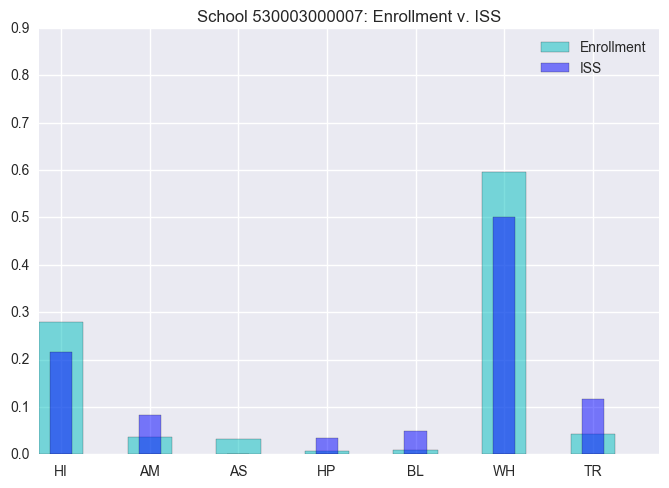

In [87]:
school_enrollment = enrollment_data_proportions.iloc[6,1:-3].values
school_iss = iss_proportions.iloc[6, 1:-3].values
indices = range(len(race_abbreviations))
width = 0.5

plt.bar(indices, school_enrollment, color='c', alpha = 0.5, width=width, label='Enrollment')
plt.bar([i+0.25*width for i in indices], school_iss, color='b', width = 0.5*width, alpha=0.5, label='ISS')


plt.xticks([i+0.5*width for i in indices], race_abbreviations)
plt.title('School {}: Enrollment v. ISS'.format(enrollment_data_clean.index[6]))
plt.ylim(0, 0.9)
plt.legend()
plt.show()